In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import mne_connectivity
import pactools
from mne_connectivity import phase_slope_index, seed_target_indices, spectral_connectivity_epochs
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra
# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
import os 
import joblib
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 

# I only want to see warnings once
warnings.filterwarnings('ignore')

from joblib import delayed, Parallel
from statsmodels.stats import multitest

Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [3]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils, statistics_utils


In [5]:
import h5io

## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

In [6]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'

# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

# Let's get rid of Iowa patients for now 

subj_df = subj_df[subj_df.Site!='UI']

days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

In [7]:
# load behavioral data
learn_df = pd.read_csv(f'{load_dir}/learn_df.csv')
combined_df = pd.read_csv(f'{load_dir}/combined_df.csv')

# Filter just to the participants in this notebook
learn_df = learn_df[learn_df.participant.isin(subj_ids)]
combined_df = combined_df[combined_df.participant.isin(subj_ids)]


# I enter the day information in stupidly 
combined_df.condition = combined_df.condition.apply(lambda x: 'Day1' if x=='day_1' else 'Day2' if x=='day_2' else np.nan)
combined_df['recog_time'] = combined_df['recog_time'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)
combined_df['baseline_start_mem'] = combined_df['baseline_start_mem'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)

# add RPE to the combined df dataframe: 

combined_df['rpe'] = np.nan
for ix, row in learn_df.iterrows():
    combined_df.loc[(combined_df.img_path==row.img_path) & (combined_df.participant==row.participant), 'rpe'] = row.rpe

## Load, pre-process and re-reference the neural data

Run the initial loading and pre-processing

In [46]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[subj_df.MSSMCode==subj_id][day].values[0] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
            # Check if path exists for saving, and if not, make it
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # electrode files could either be csv or excel
            elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
            # There should really only be one, so grab it with the zero-index 
            elec_file = elec_files[0]

            # Make MNE file
            mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                                     elec_path=elec_file,
                                                     format=format,
                                                     return_data=True,
                                                     site=site)
            
            # Save this data so that you don't need this step again:
            mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)


Working on subj MS038
Unidentified data type in blank21
Unidentified data type in blank14
Unidentified data type in mic
Unidentified data type in photo
Unidentified data type in photodiode
Unidentified data type in audio
Unidentified data type in blank12
Unidentified data type in blank11
Unidentified data type in abs2
Unidentified data type in blank22
Unidentified data type in blank23
Unidentified data type in blank13
Unidentified data type in blank15
Unidentified data type in chest1
Unidentified data type in chest2
Unidentified data type in ekg1
Unidentified data type in abs1
Creating RawArray with float64 data, n_channels=186, n_times=2157568
    Range : 0 ... 2157567 =      0.000 ...  1078.784 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:   15.1s finished


Saving photodiode data to /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day1/photodiode.fif
Writing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day1/photodiode.fif
Closing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day1/photodiode.fif
[done]
Saving EEG data to /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day1/scalp_eeg_data.fif
Writing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day1/scalp_eeg_data.fif
Closing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day1/scalp_eeg_data.fif
[done]
Number of electrodes in the mne file is greater than the number of electrodes in the localization file
       name  lev_score
147  ralmm3   0.833333
148  rammf3   0.833333
We have too many possible matches for raimm3! Select one manually from these candidates:ralmm3
       name  lev_score
147  lhpit6   0.833333
148  rhplt6   0.833333
We have too many possible matches for lhplt6! Select one manually from these candidates:lhpit6
        name  lev_score
147  rhplt10   0.857143
148 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:   18.8s finished


Saving LFP data to /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day1/lfp_data.fif
Writing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day1/lfp_data.fif
Closing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day1/lfp_data.fif
[done]
Overwriting existing file.
Writing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day1/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day1/raw_ieeg.fif
[done]
Working on subj MS038
Data in numbered files
Unidentified data type in blank12
Unidentified data type in photodiode
Unidentified data type in blank11
Unidentified data type in blank13
Unidentified data type in audio
Unidentified data type in chest2
Unidentified data type in chest1
Unidentified data type in blank14
Unidentified data type in blank22
Unidentified data type in ekg2
Unidentified data type in blank15
Unidentified data type in blank23
Unidentified data type in mic
Unidentified data type in blank21
Unidentified data type in abs1
Unidentif

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    6.1s finished


Saving photodiode data to /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day2/photodiode.fif
Writing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day2/photodiode.fif
Closing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day2/photodiode.fif
[done]
Saving EEG data to /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day2/scalp_eeg_data.fif
Writing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day2/scalp_eeg_data.fif
Closing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day2/scalp_eeg_data.fif
[done]
Number of electrodes in the mne file is greater than the number of electrodes in the localization file
       name  lev_score
147  rammf3   0.833333
148  ralmm3   0.833333
We have too many possible matches for raimm3! Select one manually from these candidates:ralmm3
       name  lev_score
147  lhpit6   0.833333
148  rhplt6   0.833333
We have too many possible matches for lhplt6! Select one manually from these candidates:lhpit6
        name  lev_score
147  lhpit10   0.857143
148 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    2.0s


Saving LFP data to /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day2/lfp_data.fif
Writing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day2/lfp_data.fif


[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:    2.6s finished


Closing /sc/arion/projects/guLab/Salman/EMU/MS038/neural/Day2/lfp_data.fif
[done]
Overwriting existing file.
Writing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day2/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day2/raw_ieeg.fif
[done]


Even though the pipeline automatically detects channels with high variance compared to the rest of the data, it can still be very useful to scroll through the data and manually click on channels that are bad (or click on automatically bad channels that are,in fact, not bad). 

Feel free to be liberal with this. Bad channels are not omitted from analysis; they are simply omitted from being used as references, so they don't spread the 'badness' to other channels.

Manually annotate bad channels for each recording: 

In [47]:
%matplotlib notebook 
# Note: this does not work in JupyterLAB. Must be done int Jupyter Notebook. 

Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day2/raw_ieeg.fif...
Isotrak not found
    Range : 0 ... 225535 =      0.000 ...   451.070 secs
Ready.
Reading 0 ... 225535  =      0.000 ...   451.070 secs...


<IPython.core.display.Javascript object>


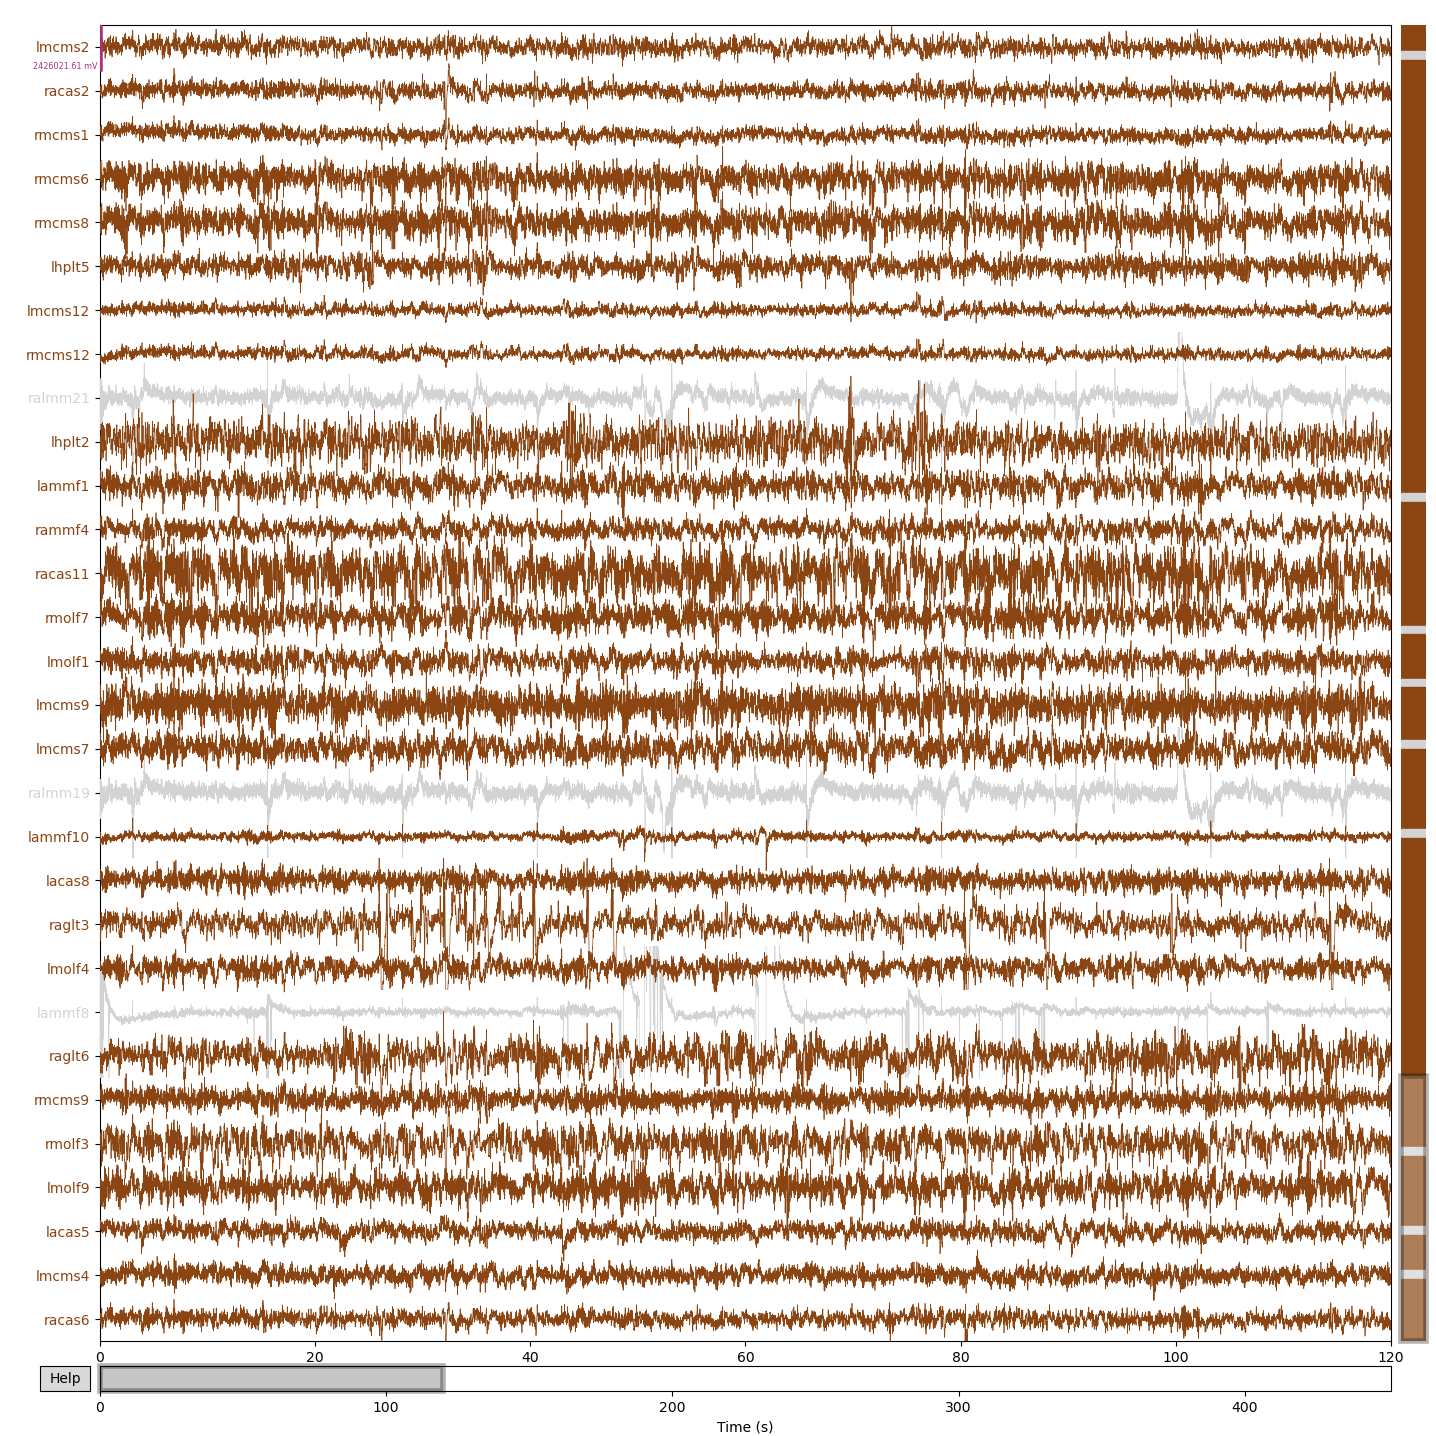

In [50]:
subj_id = 'MS038'
day = 'Day2'
save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
mne_data = mne.io.read_raw_fif(f'{save_path}/raw_ieeg.fif', preload=True)
fig = mne_data.plot(start=0, duration=120, n_channels=30, 
                      scalings=mne_data._data.max()/30
                     )

In [51]:
# Save this manual data
mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day2/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day2/raw_ieeg.fif
[done]


## Re-reference

In general, I prefer to do bipolar referencing. I still see good high-frequency activity when doing so. However, you can also do white matter referencing. 

In [21]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
            # Check if path exists for saving, and if not, make it
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # electrode files could either be csv or excel
            elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
            # There should really only be one, so grab it with the zero-index 
            elec_file = elec_files[0]

            # Make MNE file
            mne_data = mne.io.read_raw_fif(f'{save_path}/raw_ieeg.fif', preload=True)


            # Re-reference neural data
            mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                          elec_path=elec_file, 
                                                          method='bipolar', 
                                                          site=site)

            # Save this data so that you don't need this step again:
            mne_data_reref.save(f'{save_path}/bp_ref_ieeg.fif', overwrite=True)

            # Should also save out re-referenced elec_file: 
            # Weird issue to note: reference montage could change across days if a new channel becomes noisy (or a noisy channel cleans up!) 

            elec_data = lfp_preprocess_utils.load_elec(elec_file)
            anode_list = [x.split('-')[0] for x in mne_data_reref.ch_names]
            elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
            elec_df['label'] =  elec_df.label.apply(lambda x: [a for a in mne_data_reref.ch_names if str(x).lower() in a.split('-')[0]][0])

            # add region to the data frame 
            manual_col = [col for col in elec_df.columns if 'manual' in col.lower()][0]
            all_regions = [] 
            for chan_name in elec_df.label.unique():
                elec_region = analysis_utils.select_rois_picks(elec_df, chan_name, manual_col=manual_col)
                all_regions.append(elec_region) 

            elec_df['salman_region'] = all_regions
            elec_df['hemisphere'] = elec_df.label.apply(lambda x: x[0])

            elec_df.to_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df', index=False)
            

Working on subj MS012
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/raw_ieeg.fif...
Isotrak not found
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=53, n_times=394062
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Added the following bipolar channels:
racas1-racas2, racas2-racas3, racas3-racas4, racas4-racas5, racas5-racas6, racas6-racas7, racas8-racas9, racas9-racas10, raglt1-raglt2, raglt2-raglt3, raglt3-raglt4, raglt6-raglt7, raglt7-raglt8, raglt8-raglt9, rals1-rals2, rals2-rals3, rals3-rals4, rals4-rals5, rals8-rals9, rals9-rals10, rals10-rals11, rhplt1-rhplt2, rhplt2-rhplt3, rhplt3-rhplt4, rhplt7-rhplt8, rmcms3-rmcms4, rmcms4-rmcms5, rmcms7-rmcms8, rmls1-rmls2, rmls2-rmls3, rmls3-rmls4, rmls4-rmls5, rmls7-rmls8, rmls8-rmls9, rmls9-rmls10, rmolf1-rmolf2, rmolf

In [12]:
subj_df

Site MSSMCode  OtherCodes  Day1  Day2  LongVersion      Date1  \
3   MSSM    MS012         NaN     1     0          1.0 2022-08-10   
5   MSSM    MS015         NaN     1     1          1.0 2022-09-24   
6   MSSM    MS016         NaN     1     1          1.0 2022-09-24   
7   MSSM    MS017         NaN     1     1          1.0 2022-10-05   
9   MSSM    MS019         NaN     1     1          1.0 2022-12-01   
10  MSSM    MS020         NaN     1     1          1.0 2023-02-02   
11  MSSM    MS022         NaN     1     0          1.0 2023-02-05   
12  MSSM    MS023         NaN     1     1          1.0 2023-02-21   
14  MSSM    MS024         NaN     1     1          1.0 2023-03-01   
15  MSSM    MS025         NaN     1     1          1.0 2023-03-09   
16  MSSM    MS026         NaN     1     1          1.0 2023-03-23   
17  MSSM    MS028         NaN     1     0          1.0 2023-04-05   
18  MSSM    MS030         NaN     1     1          1.0 2023-06-07   
21  MSSM    MS034         NaN     1     0          1.0 2023-08-04   
22  MSSM    MS035         NaN     1     1          1.0        NaT   
23  MSSM    MS036         NaN     1     1          1.0 2023-08-16   
26  MSSM    MS038         NaN     1     1          1.0 2023-11-01   

          Experimenter  Micros  Resp  ...   Age   BDI   BAI  IQ Education  \
3              Lizbeth     0.0   0.0  ...  20.0   NaN   NaN NaN       NaN   
5     Salman + Lizbeth     0.0   0.0  ...  33.0   8.0   0.0 NaN       NaN   
6     Salman + Lizbeth     0.0   0.0  ...  24.0   1.0   0.0 NaN       NaN   
7     Salman + Lizbeth     0.0   0.0  ...  26.0  22.0  29.0 NaN       NaN   
9              Lizbeth     0.0   0.0  ...  56.0  23.0  13.0 NaN       NaN   
10             Lizbeth     1.0   0.0  ...  31.0  24.0  14.0 NaN       NaN   
11    Lizbeth + Jackie     1.0   0.0  ...  65.0  10.0  12.0 NaN       NaN   
12             Lizbeth     0.0   0.0  ...  52.0   6.0   4.0 NaN       NaN   
14             Lizbeth     1.0   0.0  ...  32.0   NaN   NaN NaN       NaN   
15  Christina + Jackie     1.0   0.0  ...  38.0   3.0  10.0 NaN       NaN   
16              Salman     1.0   1.0  ...  49.0  18.0  30.0 NaN       NaN   
17             Lizbeth     1.0   0.0  ...  32.0   2.0  12.0 NaN       NaN   
18             Lizbeth     1.0   0.0  ...   NaN   NaN   NaN NaN       NaN   
21                Alie     0.0   0.0  ...   NaN   NaN   NaN NaN       NaN   
22             Lizbeth     0.0   0.0  ...   NaN   NaN   NaN NaN       NaN   
23             Lizbeth     0.0   0.0  ...  17.0   NaN   NaN NaN       NaN   
26             Lizbeth     1.0   0.0  ...   NaN   NaN   NaN NaN       NaN   

    Handedness  Sex              Race       Ethnicity  Notes.1  
3            R   F              White    Not Hispanic      NaN  
5            R    F  African-American    Not Hispanic      NaN  
6            R    F               NaN        Hispanic      NaN  
7            R    F             Other  Latin-American      NaN  
9            R    M             White             NaN      NaN  
10           R    F               NaN             NaN      NaN  
11           R    M               NaN             NaN      NaN  
12         NaN    M               NaN             NaN      NaN  
14         NaN    M  African-American    Not Hispanic      NaN  
15         NaN    F             White    Not Hispanic      NaN  
16         NaN    F            White     Puerto Rican      NaN  
17         NaN    F  African-American    Not Hispanic      NaN  
18         NaN  NaN               NaN             NaN      NaN  
21         NaN  NaN               NaN             NaN      NaN  
22         NaN  NaN               NaN             NaN      NaN  
23         NaN  NaN               NaN             NaN      NaN  
26         NaN  NaN               NaN             NaN      NaN  

[17 rows x 26 columns]

In [9]:
%matplotlib notebook 
# Note: this does not work in JupyterLAB. Must be done int Jupyter Notebook. 

In [10]:
subj_id = 'MS020'
day = 'Day1'
save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
mne_data_reref = mne.io.read_raw_fif(f'{save_path}/bp_ref_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 592311 =      0.000 ...  1184.622 secs
Ready.
Reading 0 ... 592311  =      0.000 ...  1184.622 secs...


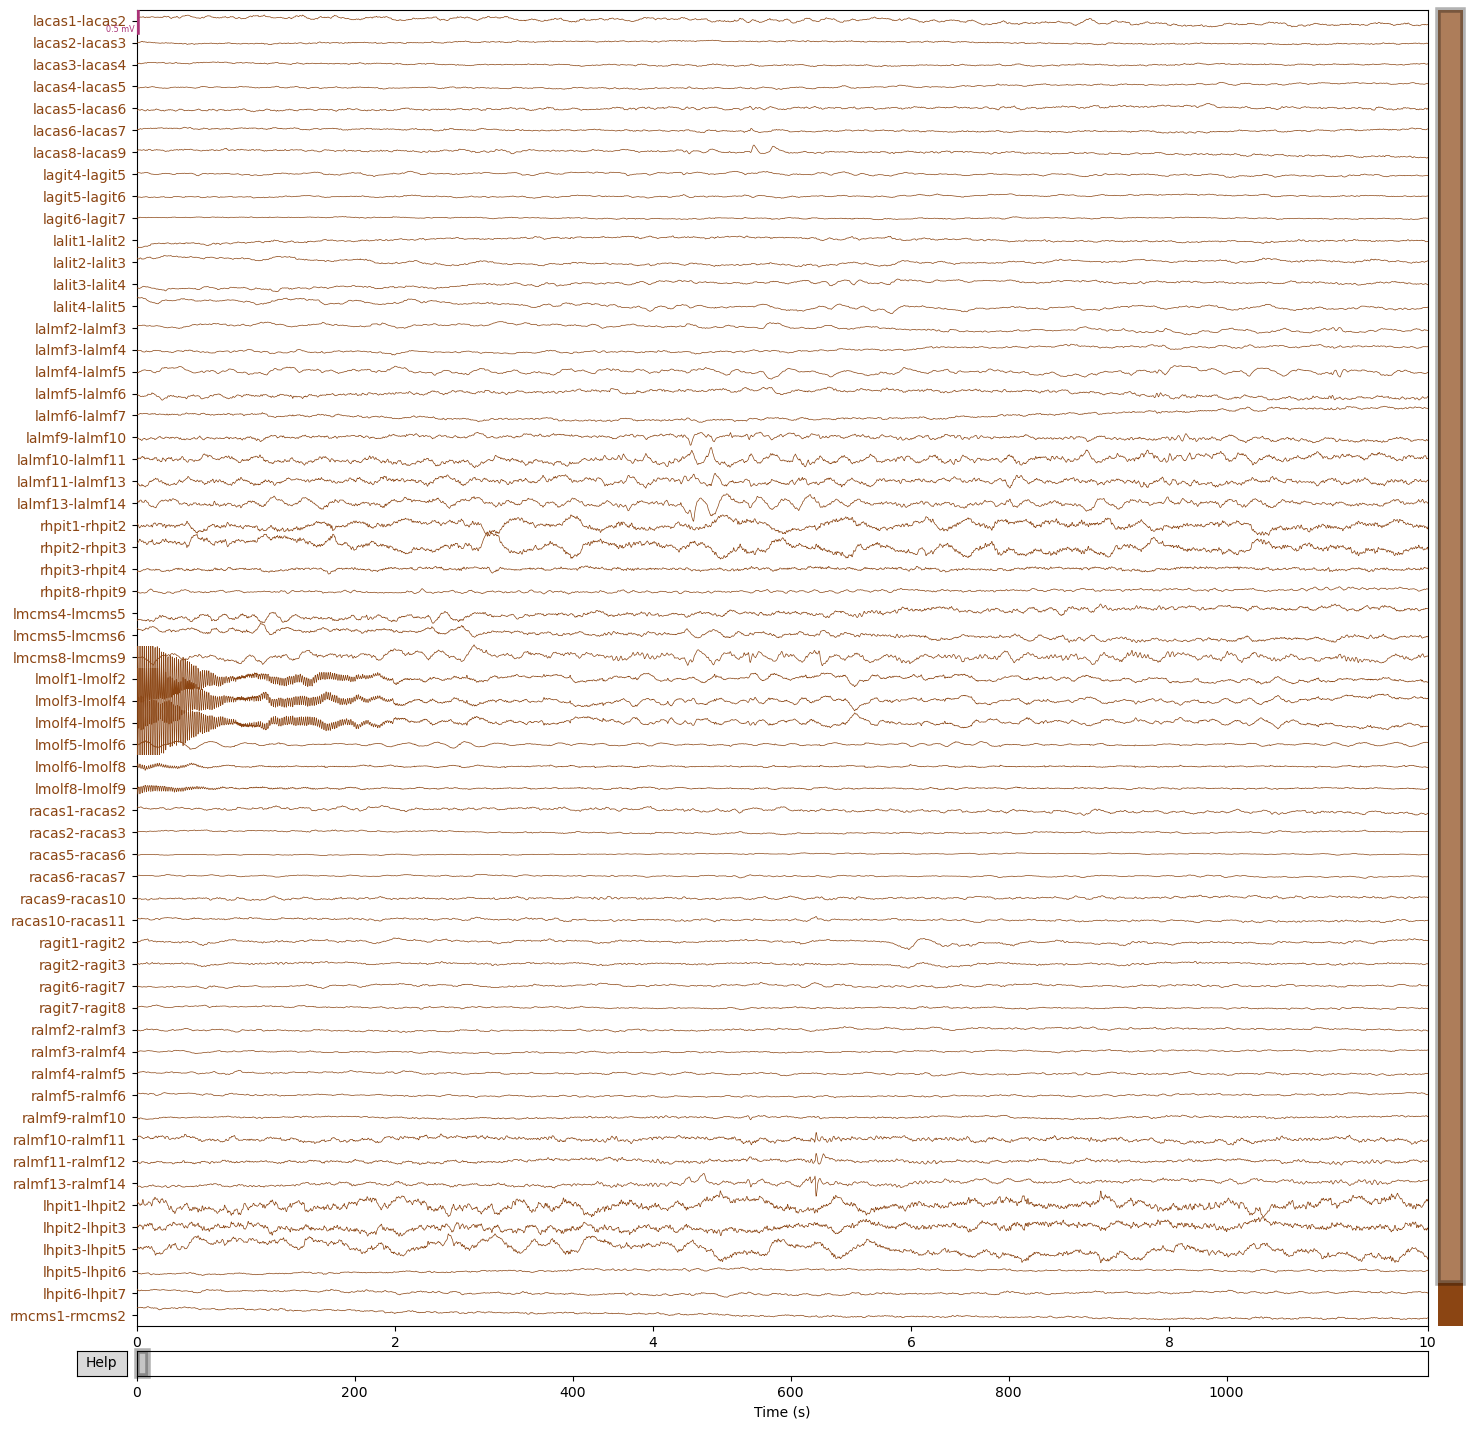

In [16]:
fig = mne_data_reref.plot(start=0, duration=10, n_channels=60, 
                      scalings=mne_data_reref._data.max()/20
                     )

 - mne_data: a Raw mne object, where the data has been loaded, filtered for line noise, searched for bad channels, parsed for different data types, and resampled if necessary. 
 
 - mne_data_reref: an mne object containing re-referenced data (either white matter or bipolar)

If you have ran the preprocessing above, load the data instead: 

In [ ]:
mne_data_reref.save(f'{save_path}/bp_ref_ieeg.fif', overwrite=True)

In [12]:
%matplotlib inline

## Load neural data

In [32]:
elec_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
mne_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
photodiode_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}

In [33]:
for ix, subj_id in enumerate(subj_ids): 
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'

            # Get electrode df 
            elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')

            mne_data_reref = mne.io.read_raw_fif(f'{save_path}/bp_ref_ieeg.fif', preload=True)

            photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)

            # Append to list 
            mne_dict[subj_id][day].append(mne_data_reref)

            photodiode_dict[subj_id][day].append(photodiode_data)

            elec_dict[subj_id][day].append(elec_df)

Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Opening raw data file /sc/arion/projects/guLab/Salman/EMU/MS012/neural/Day1/photodiode.fif...
Isotrak not found
    Range : 0 ... 807039 =      0.000 ...   788.124 secs
Ready.
Reading 0 ... 807039  =      0.000 ...   788.124 secs...
subject MS012 does not have Day 2 data
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 701187 =      0.000 ...  1402.374 secs
Ready.
Reading 0 ... 701187  =      0.000 ...  1402.374 secs...
Opening raw data file /sc/arion/projects/guLab/Salman/EMU/MS015/neural/Day1/photodiode.fif...
Isotrak not found
    Range : 0 ... 1436031 =      0.000 ...  1402.374 secs
Ready.
Reading 0 ... 1436031  =      0.000 ...  1402.374 secs...
Opening raw data file /sc/arion/projects/


 - mne_dict: a dictionary containing all of your subjects' re-referenced mne data 
 
 - photodiode_dict: a dictionary containing all of your subjects' photodiode data 
 
 - elec_dict: a dictionary containing the paths to your subjects' electrode data 

## Test out ripple detection

In [10]:
subj_id = 'MS015'
day = 'Day1' 

save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'

elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
# Load EPOCHED data, as this is what we are going to look for ripples WITHIN
mne_data_reref = mne.io.read_raw_fif(f'{save_path}/bp_ref_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 701187 =      0.000 ...  1402.374 secs
Ready.


    Using USE_HOME method to store json file
    Wrote json pkg file : /dev/shm/XALT_pkg_b8a1fc20-7825-4030-acfc-ce5afa539681/pkg.chimera.2023_12_12_10_17_10_2540.qasims01.b8a1fc20-7825-4030-acfc-ce5afa539681.a61bc8ca0bd9.json
    Using USE_HOME method to store json file
    Wrote json pkg file : /dev/shm/XALT_pkg_b8a1fc20-7825-4030-acfc-ce5afa539681/pkg.chimera.2023_12_12_10_17_10_2540.qasims01.b8a1fc20-7825-4030-acfc-ce5afa539681.8f6b2464c18c.json


Reading 0 ... 701187  =      0.000 ...  1402.374 secs...


In [11]:
RPL_samps_dict, RPL_sec_dict = analysis_utils.detect_ripple_evs(mne_data_reref, min_ripple_length=0.038, max_ripple_length=0.5, 
                      smoothing_window_length=0.02, sd_upper_cutoff=9, sd_lower_cutoff=2.5)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 80 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 83 samples (0.166 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
    Using USE_HOME method to store json file
    Using USE_HOME method to store json file
    Wrote json pkg file : /dev/shm/XALT_pkg_b8a1fc20-7825-4030-acfc-ce5afa539681/pkg.chimera.2023_12_12_10_17_10_2540.qasims01.b8a1fc20-7825-4030-acfc-ce5afa539681.61cbb13a55bd.json
    Using USE_HOME method to store json file
    Using USE_HOME method to store json file
    Wrote json pkg file : /dev/shm/XALT_pkg_b8a1fc20-7825-4030-acfc-ce5afa539681/pkg.chimera.2023_12_12_10_17_10_2540.qasims01.b8a1fc20-7825-4030-acfc-ce5afa539681.06126d70e702.json
    Wrote json pkg file : /dev/shm/XALT_pkg_b8a1fc20-7825-4030-acfc-ce5afa539681/pkg.chimera.2023_12_12_10_17_10_2540.qasims01.b8a1fc20-7825-4030-acfc-ce5afa539681.747cead7a327.json
    Using USE_HOME method to store json file
    Wrote json pkg file : /dev/shm/XALT_pkg_b8a1fc20-7825-4030-acfc-ce5afa539681/pkg.chimera.2023_12_12_10_17_10_2540.qasims01.b8a1fc20-7825-4030-acfc-ce

In [19]:
# The following code bins the ripples into the appropriate epoch according to channel for examination of spectral data

In [147]:
evs = {'gamble_start': [-1.0, 0.5],
       'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}
behav_times = learn_df[(learn_df.participant==subj_id)][event]

In [149]:
event = 'feedback_start'

In [150]:
beh_ts = behav_times

In [151]:
# Bin the ripple times into the epoched bins
ev_starts = [x + evs[event][0] for x in beh_ts]
ev_ends = [x + evs[event][1] for x in beh_ts]
dfs = []
allts = {f'{x}': np.nan for x in RPL_sec_dict.keys()}
for key in RPL_sec_dict.keys():
    
    ripple_starts_sec = np.sort([x[0] for x in RPL_sec_dict[key]])
    ripple_ends_sec = np.sort([x[1] for x in RPL_sec_dict[key]])
    
    time_bins = [(a,b) for (a,b) in zip(ev_starts, ev_ends)]

    # Initialize a dictionary to store the assigned timestamps for each time bin
    assigned_timestamps = {bin_index: [] for bin_index in range(len(time_bins))}

    # Iterate through each timestamp and assign it to the appropriate time bin
    for ix, timestamp in enumerate(ripple_starts_sec):
        for bin_index, (start, end) in enumerate(time_bins):
            if start <= timestamp <= end:
                start_in_epoch = int((timestamp - start) * mne_data_reref.info['sfreq'])
                end_in_epoch = int((ripple_ends_sec[ix] - start) * mne_data_reref.info['sfreq'])
                assigned_timestamps[bin_index].append((start_in_epoch, end_in_epoch))
    allts[key] = assigned_timestamps

In [25]:
# Load TFR data, 
filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'

event = 'feedback_start'
epoched_data = mne.time_frequency.read_tfrs(f'{filepath}/{event}-tfr.h5')[0]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/scratch/TFR/feedback_start-tfr.h5 ...
Adding metadata with 64 columns


In [26]:
epoched_data

<EpochsTFR | time : [0.000000, 1.500000], freq : [2.000000, 200.000000], epochs : 80, channels : 64, ~880.2 MB>

In [34]:
chan_name = 'lacas1-lacas2'

In [39]:
np.squeeze(epoched_data.copy().pick_channels([chan_name])[0]._data)

(30, 751)

In [165]:
epoched_data.times[0]

0.0

In [167]:
epoched_data.times[-1]

1.5

In [161]:
# 5. calculate the frequency spectrum for each detected ripple event by averaging the normalized instantaneous amplitude between the onset and offset of the ripple event for the frequency range of 2–200 Hz.
ripple_categories = {f'{x}': {epoch: [] for epoch in range(epoched_data._data.shape[0])} for x in RPL_sec_dict.keys()}
ripple_psds = {f'{x}': {epoch: [] for epoch in range(epoched_data._data.shape[0])} for x in RPL_sec_dict.keys()}
ripple_peak_widths = {f'{x}': {epoch: [] for epoch in range(epoched_data._data.shape[0])} for x in RPL_sec_dict.keys()}

for chan_name in allts.keys():
    print(chan_name)
    for epoch in allts[chan_name].keys(): 
        if allts[chan_name][epoch]: # if not empty
            tfr = np.squeeze(epoched_data.copy().pick_channels([chan_name])[0]._data)
            for ix, ripple in enumerate(allts[chan_name][epoch]):
                spectral_data = np.nanmean(tfr[:, ripple[0]:ripple[1]], axis=1)
                peaks = scipy.signal.find_peaks(spectral_data)[0]
                peak_frequencies = freqs[peaks]
                peak_prominences = scipy.signal.peak_prominences(spectral_data, peaks)[0]
                peak_widths = scipy.signal.peak_widths(spectral_data, peaks)[0]
                highest_peak_frequency = peak_frequencies[np.argmax(peak_prominences)]
                # reject events with more than one peak in peak_frequencies between 80-120 Hz 
                if len(peak_frequencies[(peak_frequencies > 80) & (peak_frequencies < 120)]) > 1:
                    ripple_categories[chan_name][epoch].append('bad')
                # reject events where most prominent peak was outside 80-120 Hz (but > 30 Hz)
                elif ((highest_peak_frequency < 80) | (highest_peak_frequency > 120)) & (highest_peak_frequency > 30):
                    ripple_categories[chan_name][epoch].append('bad')
                # reject events where HFA peaks exceed 80% of the ripple peak height 
                elif np.max(spectral_data[(freqs > 120) & (freqs < 200)]) > 0.8 * np.max(spectral_data[(freqs > 80) & (freqs < 120)]):
                    ripple_categories[chan_name][epoch].append('bad')
                else:
                    ripple_categories[chan_name][epoch].append('good')
                    ripple_psds[chan_name][epoch].append(spectral_data)
                ripple_peak_widths[chan_name][epoch].append(peak_widths[(peak_frequencies>80) & (peak_frequencies<120)])
    
    # average the spectral peaks for 'good' ripples to determine ehe mean ripple-peak width in 'spectral_data' for each electrode
    electrode_mean_peak_width = np.nanmean(sum(ripple_peak_widths[chan_name].values(), []))
    electrode_std_peak_width = np.nanstd(sum(ripple_peak_widths[chan_name].values(), []))
    # iterate through each ripple to reject events where ripple-peak width was > 3*std of the mean ripple-peak width for the electrode
    for epoch in allts[chan_name].keys():  
        if 'good' in ripple_categories[chan_name][epoch]:
            good_ripple_ix = [i for i, e in enumerate(ripple_categories[chan_name][epoch]) if e == 'good']
            for ix in good_ripple_ix:
                ripple_width = ripple_peak_widths[chan_name][epoch][ix]
                if ripple_width > electrode_mean_peak_width + 3*electrode_std_peak_width:
                    ripple_categories[chan_name][epoch][ix] = 'bad'
        
                    
    # calculate the number of ripples detected and ripple rejection rate for each electrode

    # then reject any electrode with a low ripple count (< 20 ripples detected per electrode per task) or high rejection rate (greater than 30% rejection rate)


lacas1-lacas2
lacas2-lacas4
lacas4-lacas5
lacas5-lacas6
lhplt1-lhplt2
lhplt2-lhplt3
lhplt3-lhplt4
lhplt4-lhplt5
lhplt5-lhplt7
lhplt7-lhplt8
lmcms1-lmcms5
lmcms5-lmcms6
lmcms6-lmcms7
lmolf1-lmolf2
lmolf2-lmolf3
lmolf3-lmolf4
lmolf4-lmolf5
lmolf5-lmolf6
lmolf6-lmolf7
lmolf7-lmolf9
lmolf9-lmolf10
raglt1-raglt2
raglt2-raglt3
raglt3-raglt4
raglt4-raglt6
raglt6-raglt8
raiem1-raiem2
raiem2-raiem3
raiem3-raiem4
raiem4-raiem5
raiem5-raiem6
raist1-raist2
raist2-raist3
raist3-raist4
raist4-raist5
raist5-raist6
rhplt1-rhplt3
rhplt3-rhplt4
rhplt4-rhplt5
rhplt5-rhplt6
rhplt6-rhplt7
rhplt7-rhplt10
rhplt10-rhplt11
rhplt11-rhplt12
rmcms1-rmcms2
rmcms2-rmcms4
rmcms4-rmcms5
rpem1-rpem5
rpem5-rpem6
rplem1-rplem5
rplem5-rplem6
rpmem1-rpmem2
rpmem2-rpmem3
rpmem3-rpmem4
rpmem4-rpmem5
rpmem5-rpmem6
rppem1-rppem2
rppem2-rppem5
rppem5-rppem6
rpplem1-rpplem2
rpplem2-rpplem3
rpplem3-rpplem4
rpplem4-rpplem5
rpplem5-rpplem6


In [162]:
ripple_categories

{'lacas1-lacas2': {0: [],
  1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: [],
  16: [],
  17: [],
  18: [],
  19: [],
  20: [],
  21: [],
  22: [],
  23: [],
  24: [],
  25: [],
  26: [],
  27: [],
  28: [],
  29: [],
  30: [],
  31: [],
  32: [],
  33: [],
  34: [],
  35: [],
  36: [],
  37: [],
  38: [],
  39: [],
  40: [],
  41: [],
  42: [],
  43: [],
  44: [],
  45: [],
  46: [],
  47: [],
  48: [],
  49: [],
  50: [],
  51: ['good'],
  52: [],
  53: [],
  54: [],
  55: [],
  56: [],
  57: [],
  58: [],
  59: [],
  60: [],
  61: [],
  62: [],
  63: [],
  64: [],
  65: [],
  66: [],
  67: [],
  68: [],
  69: [],
  70: [],
  71: [],
  72: [],
  73: [],
  74: [],
  75: [],
  76: [],
  77: [],
  78: [],
  79: []},
 'lacas2-lacas4': {0: [],
  1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: ['bad'],
  8: [],
  9: [],
  10: ['good', 'bad', 'bad'],
  11: [],
  12: [],
  13: [],
  14: [],
  15

In [158]:
ripple_peak_widths[chan_name][epoch][0]

array([1.95575094])

In [139]:
freqs = np.logspace(*np.log10([2, 200]), num=30)


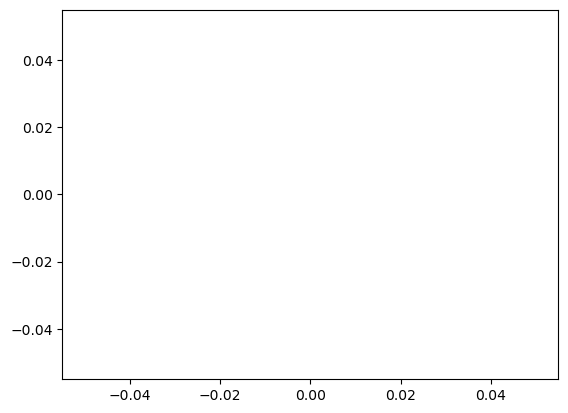

In [140]:
plt.plot(freqs, spectral_data)

In [ ]:
# 6. spectral amplitude was normalized to a percent change signal by applying a baseline correction at each frequency based on the mean amplitude of the entire recording for a given electrode and frequency



In [ ]:
#     7. reject events with more than one peak in the ripple band



In [ ]:
#     8. reject events where the most prominent and highest peak was outside the ripple band and sharp wave band for a frequencies > 30 Hz



In [ ]:
#     9. reject events where ripple-peak width was greater than 3 standard deviations from the mean ripple-peak width calculated for a given electrode and recording session
  
    

In [ ]:
#     10. reject events where high frequency activity peaks exceed 80% of the ripple peak height



## Sync behavioral and neural data



Here, we perform a critical step: computing the time offset between the computer that recorded the neural data and the laptop that featured the experiment. 

The function here only requires a **subset** of detected sync signals (i.e. photodiode deflections) to be detected to successfully compute this offset. 


First, some of the photodiode data can be a bit crummy, which you need to clean up in an idiosyncratic way... ugh

In [34]:
subj_id = 'MS015'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0, :]
temp_diode[900000:] = np.nanmin(temp_diode)
# photodiode_dict[subj_id][day][0]._data = temp_diode[0:420000]
# temp_diode[temp_diode>.13] = 0.1
photodiode_dict[subj_id][day][0]._data = temp_diode


subj_id = 'MS022'
day = 'Day1'
temp_diode = np.abs(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>.13] = 0.1
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS026'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0,:]
temp_diode[temp_diode>4000] = 0
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS028'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0,:]
temp_diode[temp_diode>4000] = 0
temp_diode[temp_diode<-3000] = 0
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS030'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0,:]
temp_diode[temp_diode>0.005] = 0.005
temp_diode[temp_diode>-0.002] = 0.004
temp_diode[temp_diode<-0.004] = -0.004
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS034'
day = 'Day1'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>-0.225] = -0.225
temp_diode[temp_diode>-0.2375] = -0.225
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS035'
day = 'Day1'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>-0.25] = -0.25
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS035'
day = 'Day2'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>-0.25] = -0.25
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS036'
day = 'Day1'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
photodiode_dict[subj_id][day][0]._data = temp_diode


subj_id = 'MS036'
day = 'Day2'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS038'
day = 'Day1'
temp_diode = (photodiode_dict[subj_id][day][0]._data[0,:])
# temp_diode[temp_diode<0] = 0
# photodiode_dict[subj_id][day][0]._data = temp_diode

Now, let's compute the slopes and offsets

In [36]:
slopes = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
offsets = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}


for ix, subj_id in enumerate(subj_ids):
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Load the behavioral timestamps: 
            behav_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/behav/{day}'
            temp_df = pd.read_csv(glob(f'{behav_path}/*.csv')[0], index_col=None, header=0)
            # Load in the timestamps pertaining to your sync. If your task had a square pop up, for example, grab the times for that square's appearance from the behavioral logs.
            # Below, I do this for my own task's Psychopy output, but yours is probably coded differently. 
            beh_ts = temp_df[temp_df.keys()[temp_df.keys().str.startswith('sync') & temp_df.keys().str.endswith('started')]].values
            beh_ts = beh_ts[~np.isnan(beh_ts)] 

            # Synchronize to the photodiode or whatever your neural sync signal is
            height = 1
            windSize = 15
            smoothSize = 11
            
            # Can sometimes help to set some parameters manually for individuals with bad signal 
            if subj_id in ['MS015']:
                if day == 'Day1':
                    height = 1
                    windSize = 35
                    smoothSize = 10
                elif day == 'Day2':
                    height = 1.5
                    windSize = 20
                    smoothSize = 11                  
            if subj_id in ['MS020']:
                if day == 'Day1':
                    height = 1.5
            if subj_id in ['MS038']:
                if day == 'Day1':
                    height = 1
                    windSize = 35
#             elif subj_id in ['MS022', 'MS025', 'MS026']:
#                 if day == 'Day1':
#                     height = 2
#             elif subj_id in ['MS028']:
#                 if day == 'Day1':
#                     height = 0.5            
            slope, offset = sync_utils.synchronize_data(beh_ts, 
                                                        photodiode_dict[subj_id][day][0], 
                                                        smoothSize=smoothSize, windSize=windSize, height=height)

            print(slope)
            print(offset)
            slopes[subj_id][day].append(slope)
            offsets[subj_id][day].append(offset)


Working on subj MS012
28 blocks
............................

found matches for 150 of 428 pulses
21 blocks
.....................

found matches for 120 of 428 pulses
17 blocks
.................

found matches for 125 of 428 pulses
14 blocks
..............

found matches for 120 of 428 pulses
0.9999945194238038
-228.21235840062207
subject MS012 does not have Day 2 data
Working on subj MS015
10 blocks
..........

found matches for 70 of 380 pulses
1.0000079676436004
-714.138367224609
Working on subj MS015
8 blocks
........

found matches for 160 of 164 pulses
1.0000113058767246
-49.50983715944465
Working on subj MS016
28 blocks
............................

found matches for 315 of 426 pulses
21 blocks
.....................

found matches for 320 of 426 pulses
17 blocks
.................

found matches for 200 of 426 pulses
0.9999811557796215
-102.81012973938641
Working on subj MS016
9 blocks
.........

found matches for 75 of 139 pulses
6 blocks
......

found matches for 60 of 139 puls

In [41]:
# Save the sync info
file = f'{base_dir}/projects/guLab/Salman/EMU/slopes.json'
with open(file, 'wb') as f: 
    pickle.dump(slopes, f, pickle.HIGHEST_PROTOCOL)
    f.close()
file = f'{base_dir}/projects/guLab/Salman/EMU/offsets.json'
with open(file, 'wb') as f: 
    pickle.dump(offsets, f, pickle.HIGHEST_PROTOCOL)
    f.close()


In [64]:
# slopes['MS038']['Day1'] = [] 
# offsets['MS038']['Day1'] = []


 - slopes: a dictionary containing the slopes (should be ~ 1) for each subject
 - offsets: a dictionary containing the offsets for each subject

Note: The slope should always be VERY close to 1! If you run into issues with syncing downstream, come back and check this... 

## Load the sync data

In [39]:
# Load the sync info
file = f'{base_dir}/projects/guLab/Salman/EMU/slopes.json'
with open(file, 'rb') as f: 
    slopes2 = pickle.load(f)
file = f'{base_dir}/projects/guLab/Salman/EMU/offsets.json'
with open(file, 'rb') as f: 
    offsets2 = pickle.load(f)


Note: I have two different tasks in one experiment

1) Decision-making 
2) Memory

Furthermore, the memory task is split into Day 1 and Day 2. So really, it's like having three tasks in one. So I will be performing the same steps repeatedly.

## Make epochs (decision-making task)

Make epochs and remove IEDs. Currently just doing this for one example period - when subjects receive feedback.

In [42]:
# set some windows of interest 

buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

# evs = ['gamble_start', 'feedback_start', 'baseline_start']
evs = {'gamble_start': [-1.0, 0.5],
       'feedback_start': [-0.5, 1.5],
       'baseline_start': [0, 0.75]}


# add behavioral times of interest 
for subj_id in subj_ids:
    for day in ['Day1']:
        # Set paths
        load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
        save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'

        epochs_all_evs = {f'{x}': np.nan for x in evs}
        for event in evs.keys():
            pre = evs[event][0]
            post = evs[event][1]
            fixed_baseline = None
            behav_times = learn_df[(learn_df.participant==subj_id)][event]

            epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}/bp_ref_ieeg.fif', 
                                                      slope=slopes[subj_id][day][0], offset=offsets[subj_id][day][0], 
                                                      behav_name=event, behav_times=behav_times,
                                                      ev_start_s=pre, ev_end_s=post, buf_s=1, downsamp_factor=None, IED_args=IED_args)

            
            epochs_all_evs[event] = epochs
            epochs_all_evs[event].save(f'{save_path}/{event}-epo.fif', overwrite=True)

        



Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.1s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 53 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.1s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 53 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.1s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 53 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 701187 =      0.000 ...  1402.374 secs
Ready.
Reading 0 ... 701187  =      0.000 ...  1402.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 22 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 701187 =      0.000 ...  1402.374 secs
Ready.
Reading 0 ... 701187  =      0.000 ...  1402.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 22 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 701187 =      0.000 ...  1402.374 secs
Ready.
Reading 0 ... 701187  =      0.000 ...  1402.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.1s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 22 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 737811 =      0.000 ...  1475.622 secs
Ready.
Reading 0 ... 737811  =      0.000 ...  1475.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    2.2s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 51 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 737811 =      0.000 ...  1475.622 secs
Ready.
Reading 0 ... 737811  =      0.000 ...  1475.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    2.2s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 51 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 737811 =      0.000 ...  1475.622 secs
Ready.
Reading 0 ... 737811  =      0.000 ...  1475.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    2.2s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 51 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 407811 =      0.000 ...   815.622 secs
Ready.
Reading 0 ... 407811  =      0.000 ...   815.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.1s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 51 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 407811 =      0.000 ...   815.622 secs
Ready.
Reading 0 ... 407811  =      0.000 ...   815.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.1s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 51 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 407811 =      0.000 ...   815.622 secs
Ready.
Reading 0 ... 407811  =      0.000 ...   815.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.1s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 51 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 883624 =      0.000 ...  1767.248 secs
Ready.
Reading 0 ... 883624  =      0.000 ...  1767.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    3.0s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 59 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 883624 =      0.000 ...  1767.248 secs
Ready.
Reading 0 ... 883624  =      0.000 ...  1767.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    3.0s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 59 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 883624 =      0.000 ...  1767.248 secs
Ready.
Reading 0 ... 883624  =      0.000 ...  1767.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    3.0s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 59 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 592311 =      0.000 ...  1184.622 secs
Ready.
Reading 0 ... 592311  =      0.000 ...  1184.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.9s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 62 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 592311 =      0.000 ...  1184.622 secs
Ready.
Reading 0 ... 592311  =      0.000 ...  1184.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.9s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 62 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 592311 =      0.000 ...  1184.622 secs
Ready.
Reading 0 ... 592311  =      0.000 ...  1184.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.9s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 62 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 1214374 =      0.000 ...  2428.748 secs
Ready.
Reading 0 ... 1214374  =      0.000 ...  2428.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.1s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 36 columns
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 1214374 =      0.000 ...  2428.748 secs
Ready.
Reading 0 ... 1214374  =      0.000 ...  2428.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.1s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 36 columns
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 1214374 =      0.000 ...  2428.748 secs
Ready.
Reading 0 ... 1214374  =      0.000 ...  2428.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.4s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 36 columns
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 896499 =      0.000 ...  1792.998 secs
Ready.
Reading 0 ... 896499  =      0.000 ...  1792.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.1s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 80 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 896499 =      0.000 ...  1792.998 secs
Ready.
Reading 0 ... 896499  =      0.000 ...  1792.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.1s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 80 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 896499 =      0.000 ...  1792.998 secs
Ready.
Reading 0 ... 896499  =      0.000 ...  1792.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.1s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 80 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS024/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 356468 =      0.000 ...   712.936 secs
Ready.
Reading 0 ... 356468  =      0.000 ...   712.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    1.5s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 83 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS024/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 356468 =      0.000 ...   712.936 secs
Ready.
Reading 0 ... 356468  =      0.000 ...   712.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    1.5s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 83 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS024/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 356468 =      0.000 ...   712.936 secs
Ready.
Reading 0 ... 356468  =      0.000 ...   712.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    1.5s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 83 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 534187 =      0.000 ...  1068.374 secs
Ready.
Reading 0 ... 534187  =      0.000 ...  1068.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    2.4s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 85 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 534187 =      0.000 ...  1068.374 secs
Ready.
Reading 0 ... 534187  =      0.000 ...  1068.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    2.4s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 85 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 534187 =      0.000 ...  1068.374 secs
Ready.
Reading 0 ... 534187  =      0.000 ...  1068.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    2.4s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 85 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 842415 =      0.000 ...  1684.830 secs
Ready.
Reading 0 ... 842415  =      0.000 ...  1684.830 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    3.0s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 61 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 842415 =      0.000 ...  1684.830 secs
Ready.
Reading 0 ... 842415  =      0.000 ...  1684.830 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    3.1s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 61 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 842415 =      0.000 ...  1684.830 secs
Ready.
Reading 0 ... 842415  =      0.000 ...  1684.830 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    3.0s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 61 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 609175 =      0.000 ...  1218.350 secs
Ready.
Reading 0 ... 609175  =      0.000 ...  1218.350 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    3.1s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 96 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 609175 =      0.000 ...  1218.350 secs
Ready.
Reading 0 ... 609175  =      0.000 ...  1218.350 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    3.1s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 96 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 609175 =      0.000 ...  1218.350 secs
Ready.
Reading 0 ... 609175  =      0.000 ...  1218.350 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    3.1s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 96 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 417968 =      0.000 ...   835.936 secs
Ready.
Reading 0 ... 417968  =      0.000 ...   835.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
-

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.4s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 60 columns
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 417968 =      0.000 ...   835.936 secs
Ready.
Reading 0 ... 417968  =      0.000 ...   835.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
-

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.4s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 60 columns
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 417968 =      0.000 ...   835.936 secs
Ready.
Reading 0 ... 417968  =      0.000 ...   835.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.4s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 60 columns
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS034/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 455093 =      0.000 ...   910.186 secs
Ready.
Reading 0 ... 455093  =      0.000 ...   910.186 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.5s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 62 columns
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS034/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 455093 =      0.000 ...   910.186 secs
Ready.
Reading 0 ... 455093  =      0.000 ...   910.186 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
-

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.5s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 62 columns
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS034/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 455093 =      0.000 ...   910.186 secs
Ready.
Reading 0 ... 455093  =      0.000 ...   910.186 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.5s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 62 columns
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 611843 =      0.000 ...  1223.686 secs
Ready.
Reading 0 ... 611843  =      0.000 ...  1223.686 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    3.3s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 104 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 611843 =      0.000 ...  1223.686 secs
Ready.
Reading 0 ... 611843  =      0.000 ...  1223.686 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    3.3s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 104 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 611843 =      0.000 ...  1223.686 secs
Ready.
Reading 0 ... 611843  =      0.000 ...  1223.686 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper t

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    3.3s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 104 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper t

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    1.9s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 78 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    1.9s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 78 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    1.9s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 78 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 539391 =      0.000 ...  1078.782 secs
Ready.
Reading 0 ... 539391  =      0.000 ...  1078.782 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    2.1s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Adding metadata with 74 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 539391 =      0.000 ...  1078.782 secs
Ready.
Reading 0 ... 539391  =      0.000 ...  1078.782 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tran

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    2.1s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Adding metadata with 74 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 539391 =      0.000 ...  1078.782 secs
Ready.
Reading 0 ... 539391  =      0.000 ...  1078.782 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tr

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    2.1s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 74 columns
Overwriting existing file.


## Make epochs (memory)

In [109]:
# # set some windows of interest 

# buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

# IED_args = {'peak_thresh':4,
#            'closeness_thresh':0.25, 
#            'width_thresh':0.2}

# evs = {'recog_time': [-1.0, 0.0],
#        'baseline_start_mem': [0, 0.75]}


# # add behavioral times of interest 
# for ix, subj_id in enumerate(subj_ids):
#     for day in ['Day1', 'Day2']: 
#         if (day=='Day2') & (subj_days[ix]==0):
#             continue
#         else:
#             # Set paths
#             load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
#             save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'

#             epochs_all_evs = {f'{x}': np.nan for x in evs}
#             for event in evs.keys():
#                 pre = evs[event][0]
#                 post = evs[event][1]
#                 fixed_baseline = None
#                 behav_times = combined_df[(combined_df.participant==subj_id) & (combined_df.condition==day)][event]

#     #             baseline_times = combined_df[(combined_df.participant==subj_id) & (combined_df.condition==f'{day}')].dropna(subset='trials_gamble').baseline_start_mem

#                 epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}/bp_ref_ieeg.fif', 
#                                                           slope=slopes[subj_id][day][0], offset=offsets[subj_id][day][0], 
#                                                           behav_name=event, behav_times=behav_times,
#                                                           ev_start_s=pre, ev_end_s=post, buf_s=1, downsamp_factor=None, IED_args=IED_args)


#                 epochs_all_evs[event] = epochs
#                 epochs_all_evs[event].save(f'{save_path}/{event}-epo.fif', overwrite=True)





Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS034/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 455093 =      0.000 ...   910.186 secs
Ready.
Reading 0 ... 455093  =      0.000 ...   910.186 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 130 out of 139 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    2.2s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 79 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 139 columns
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS034/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 455093 =      0.000 ...   910.186 secs
Ready.
Reading 0 ... 455093  =      0.000 ...   910.186 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    1.4s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 139 columns
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 611843 =      0.000 ...  1223.686 secs
Ready.
Reading 0 ... 611843  =      0.000 ...  1223.686 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    1.9s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 151 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 611843 =      0.000 ...  1223.686 secs
Ready.
Reading 0 ... 611843  =      0.000 ...  1223.686 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper trans

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    2.0s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 151 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day2/bp_ref_ieeg.fif...
    Range : 0 ... 307624 =      0.000 ...   615.248 secs
Ready.
Reading 0 ... 307624  =      0.000 ...   615.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upp

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.9s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 145 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day2/bp_ref_ieeg.fif...
    Range : 0 ... 307624 =      0.000 ...   615.248 secs
Ready.
Reading 0 ... 307624  =      0.000 ...   615.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper trans

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.9s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 145 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upp

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.2s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 126 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper trans

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.2s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 126 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day2/bp_ref_ieeg.fif...
    Range : 0 ... 199218 =      0.000 ...   398.436 secs
Ready.
Reading 0 ... 199218  =      0.000 ...   398.436 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upp

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.5s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 125 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day2/bp_ref_ieeg.fif...
    Range : 0 ... 199218 =      0.000 ...   398.436 secs
Ready.
Reading 0 ... 199218  =      0.000 ...   398.436 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper trans

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.5s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 125 columns
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 539391 =      0.000 ...  1078.782 secs
Ready.
Reading 0 ... 539391  =      0.000 ...  1078.782 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upp

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.5s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 126 columns
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 539391 =      0.000 ...  1078.782 secs
Ready.
Reading 0 ... 539391  =      0.000 ...  1078.782 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    1.5s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 126 columns
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day2/bp_ref_ieeg.fif...
    Range : 0 ... 225535 =      0.000 ...   451.070 secs
Ready.
Reading 0 ... 225535  =      0.000 ...   451.070 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.5s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 6 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 127 columns
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day2/bp_ref_ieeg.fif...
    Range : 0 ... 225535 =      0.000 ...   451.070 secs
Ready.
Reading 0 ... 225535  =      0.000 ...   451.070 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:    0.5s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Adding metadata with 127 columns


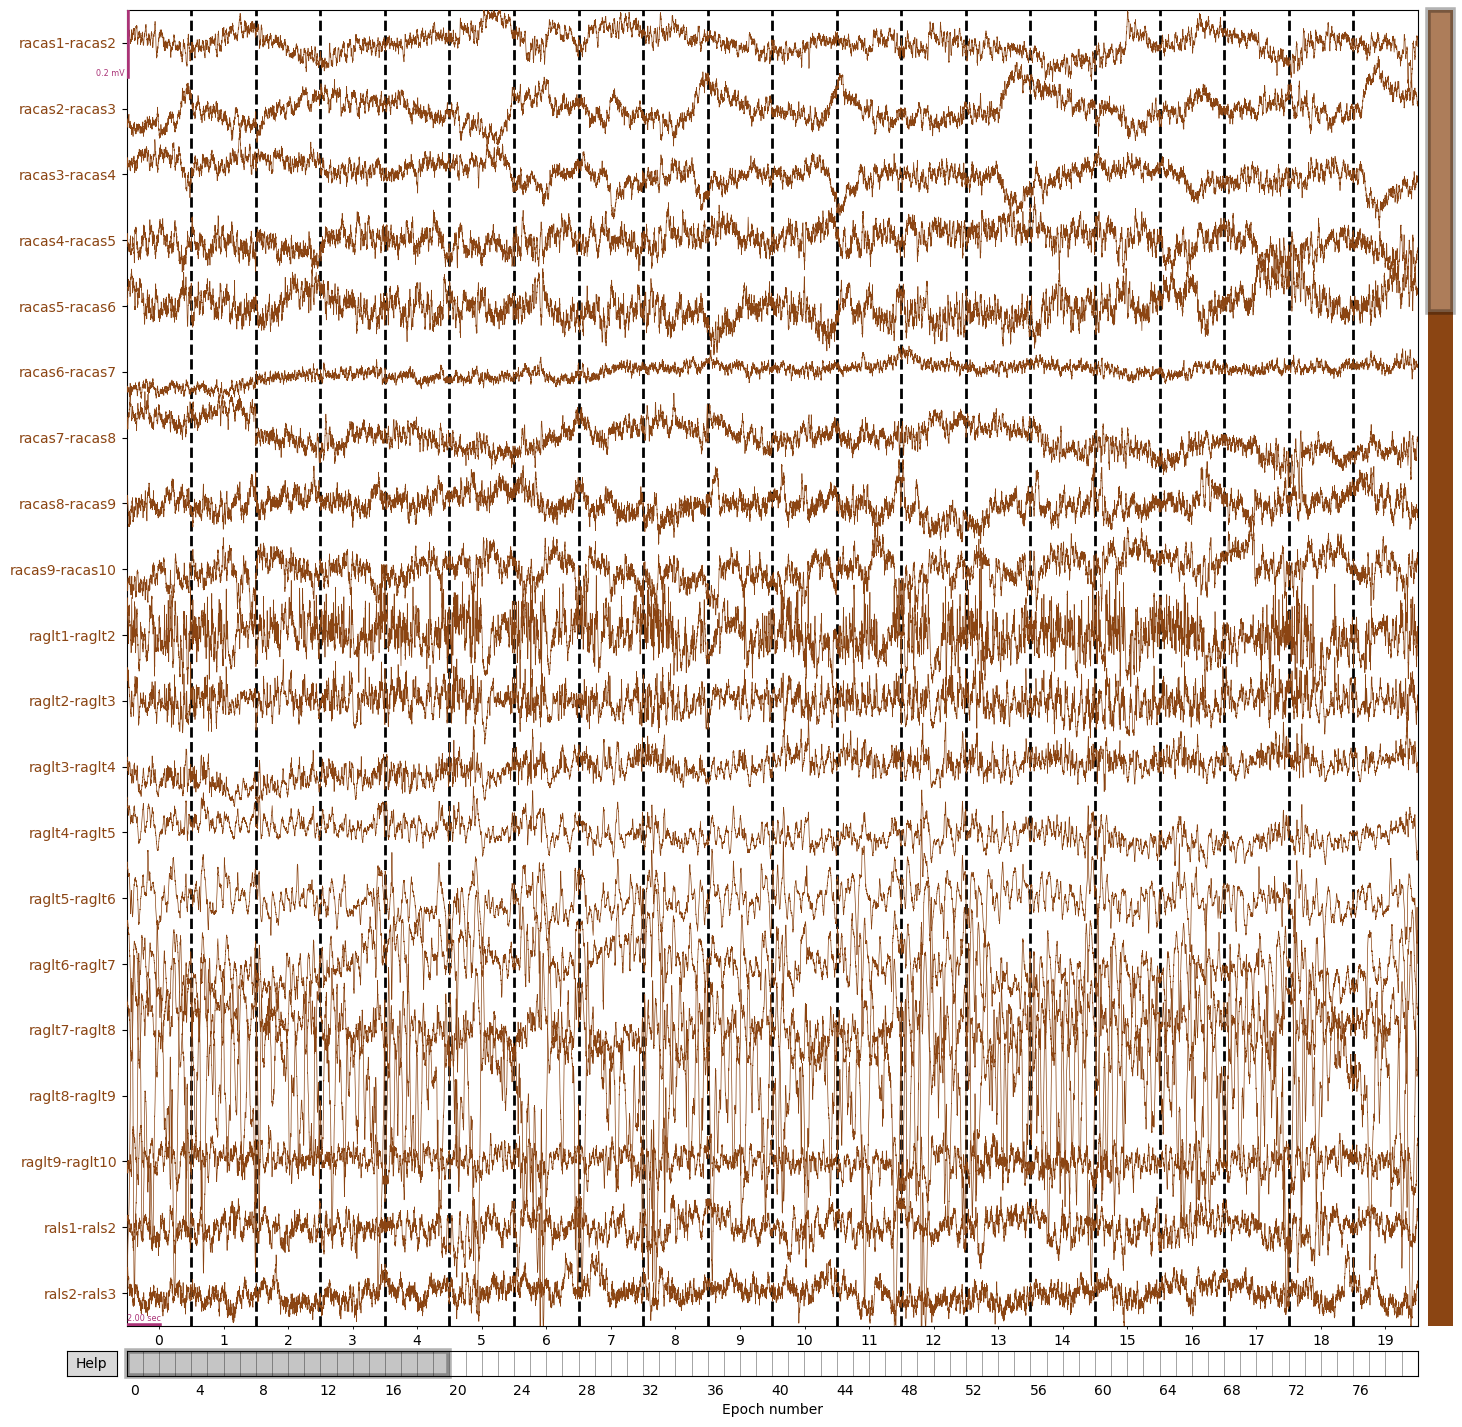

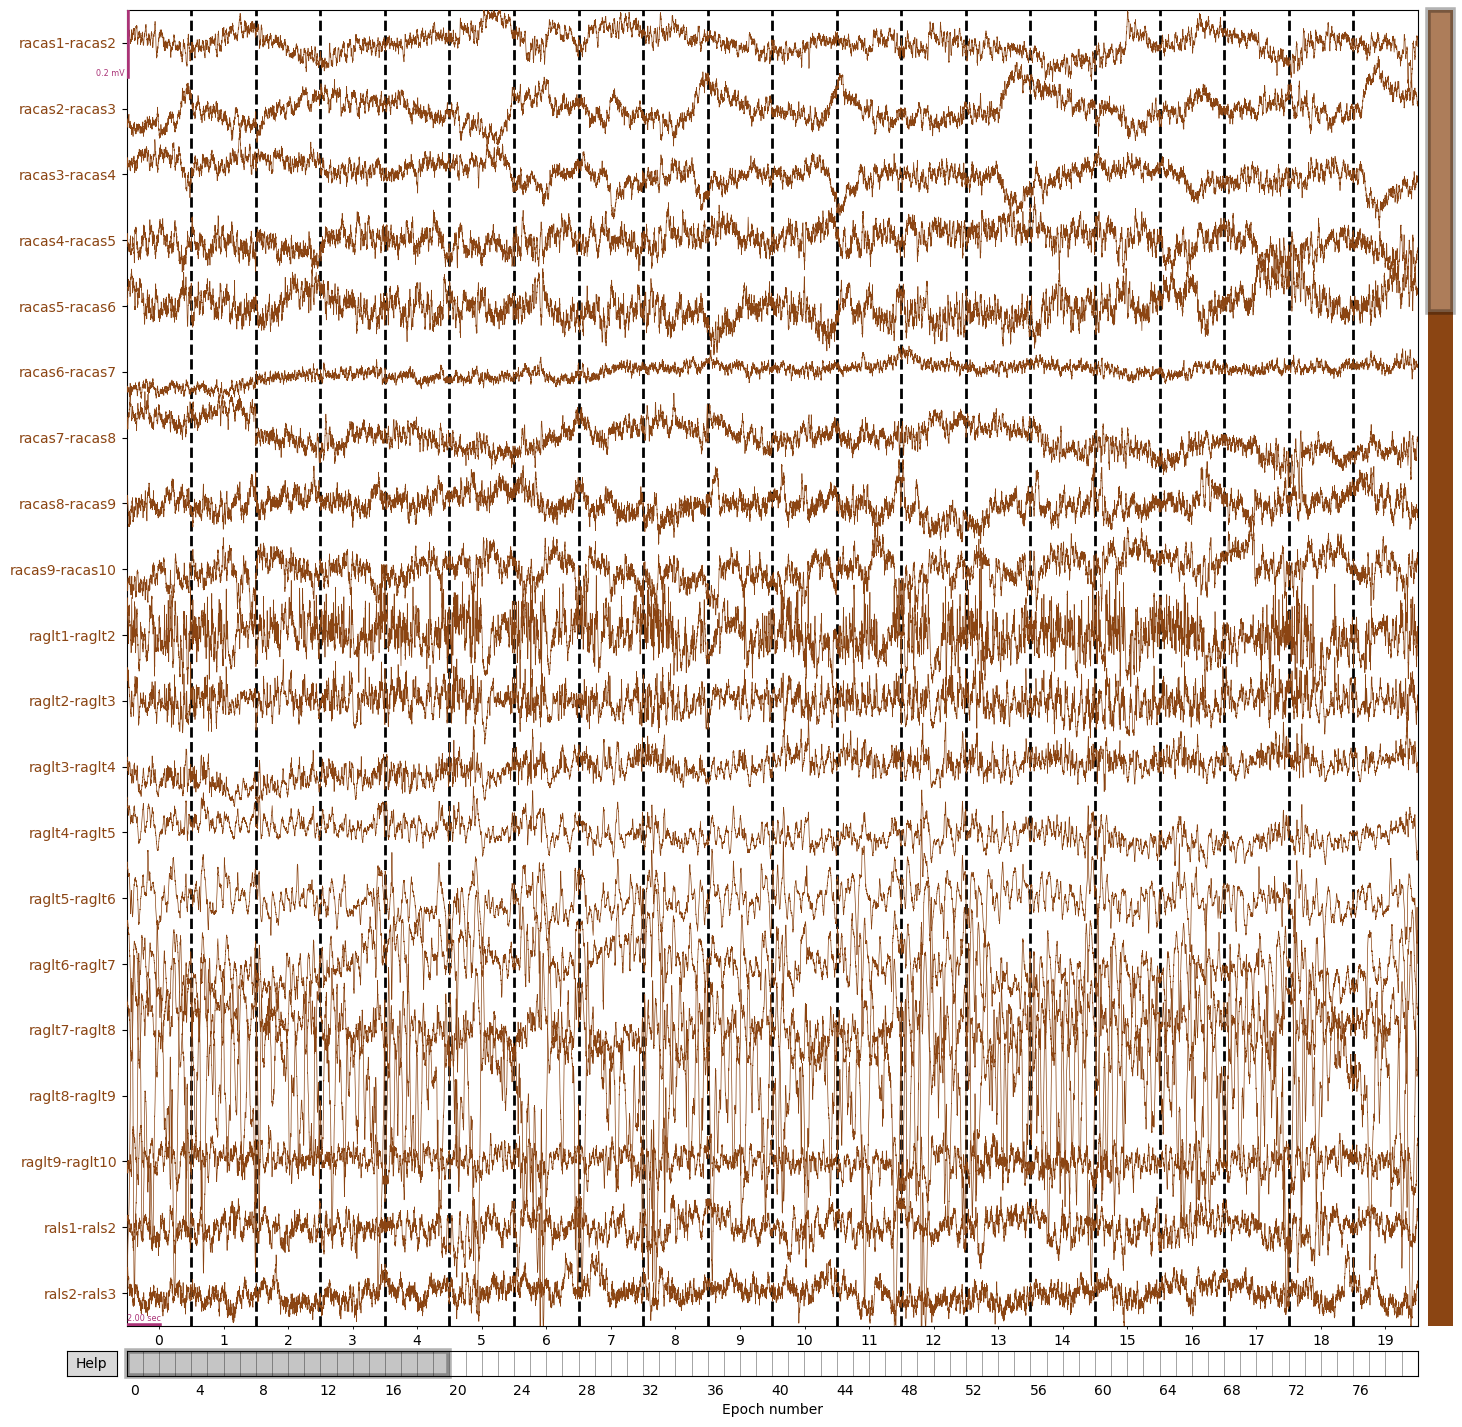

In [ ]:
epochs.plot()

## Extract the relevant dataframes and plots for one subject before expanding to group analysis: 

We probably want to produce two dataframes: 

1. Electrode-level: This is the highest-level dataframe, which is computing electrode-level traits for all trials, which cannot be computed at the trial-level, as well as parsing by conditions. Should be mergeable with the next level.

2. Trial-level: This is the second-level dataframe, which is computing trial-level traits for each electrode. 

3. Timewise: This is the third-level dataframe, used sparingly. It will include timepoints for time-specific results. 

This involves running a series of analyses: 


0. Compute power spectrum 

1. FOOOF (all trials) 

2. FOOOF (conditions) 

3. TFR 

4. eBOSC 

5. catch-22 traits (ML)

6. ripple algorithm (TBD)

7. temporally-resolved regression (optional - timewise)

8. connectivity 

9. pac 


Each analysis also has the potential to generate both data objects as well as plots that we might want to sve. We should make it optional as to whether all these exhaust fumes should actually be saved or not. 

In [131]:
# electrode_level_data = pd.DataFrame(columns=['task', 'subject', 'channel', 'region', 'condition', 'frequency', 'PSD_raw', 'PSD_corrected', 'in_FOOOF_peak', 'PSD_exp', 'TFR']) 
# trial_level_data = pd.DataFrame(columns=['task', 'subject', 'channel', 'region', 'condition', 'frequency', 'trial', 'TFR', 'BOSC', 'ripple_rate'])
         
# timewise_data = pd.DataFrame(columns=['task', 'subject', 'channel', 'region', 'condition', 'frequency', 'trial', 'time'])
    

In [13]:
# Load one person's data 
subj_id = 'MS012'
day = 'Day1'
save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'

mne_data_reref = mne.read_epochs(f'{save_path}/feedback_start-epo.fif', preload=True)

elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')


# # Put in the behavioral data for the different tasks

# evs_for_dm_only = behav_data[(behav_data.participant==subj_id)]

# evs_for_dm_and_mem = combined_df[(combined_df.participant==subj_id)].sort_values(by=['trials_gamble']).reset_index(drop=True)

# mne_data_reref.metadata = evs_for_dm_only



Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 83 columns
80 matching events found
No baseline correction applied
0 projection items activated


In [112]:
pwise

(24, 2001)

## Time-series characteristics (Catch-22) 

Here, we aim to characterize some linear AND non-linear explanatory features of our timeseries. I don't use this much yet but useful for ML approaches. 

In [330]:
# import warnings
# warnings.filterwarnings('ignore')

In [504]:
# ev_dict = {'feedback_start': [-0.5, 1.5]}

# #        'baseline_start': [0, 0.75]
# # 'gamble_start': [-1.0, 0.5],

# # Define peak_width, peak_height, peak_threshold, max_n_peaks
# FOOOF_kwargs = {'peak_width_limits': [1, 8], 
#                'min_peak_height': 0.1,
#                 'peak_threshold': 1.,
#                 'max_n_peaks': 3,
#                'freq_range': [1, 30]}
 
# # Define our frequency bands of interest
# band_dict = {'delta' : [1, 4],
#                'theta' : [4, 8],
#                'alpha' : [8, 13],
#                'beta' : [13, 30]}

# conditions = ['rpe>0',
#              'rpe<1']


# # For now, let's go channel-by-channel, otherwise I would define our ROIs as such:
# rois = ['hippocampus', 'amygdala', 'insula', 'parahippocampal', 'entorhinal', 'anterior_cingulate']

# all_dfs = []

# for ix, subj_id in enumerate(subj_ids):
#     # Load one person's data 
#     for day in ['Day1']:
#         load_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
#         for event in ev_dict.keys():   
#             # filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/FOOOF/{event}'
#             # if not os.path.exists(f'{filepath}/plots'):
#             #     os.makedirs(f'{filepath}/plots')
#             # if not os.path.exists(f'{filepath}/dfs'):
#             #     os.makedirs(f'{filepath}/dfs')

#             mne_data_reref = mne.read_epochs(f'{load_path}/{event}-epo.fif', preload=True)
#             # Put in the behavioral data for the different tasks
#             evs_for_dm_only = behav_data[(behav_data.participant==subj_id)]
#             evs_for_dm_and_mem = combined_df[(combined_df.participant==subj_id)]
#             mne_data_reref.metadata = evs_for_dm_only
            
#             if evs_for_dm_and_mem.shape[0]<160: 
#                 print('not enough recalls') 
#                 continue

#             save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}'
#             # Get electrode df 
#             elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
#             # electrode files could either be csv or excel
#             elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
#             # There should really only be one 
#             elec_file = elec_files[0]

#         #     # IF Picking ROI: Revise labelling in electrode csv in order to match the re-referenced channel names 
#             elec_data = lfp_preprocess_utils.load_elec(elec_file)
#             anode_list = [x.split('-')[0] for x in mne_data_reref.ch_names]
#             elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
#             elec_df['label'] =  elec_df.label.apply(lambda x: [a for a in mne_data_reref.ch_names if str(x).lower() in a.split('-')[0]][0])

#             all_aucs = []
#             all_chans = [] 
#             all_regions = [] 

#             progress_bar = tqdm(mne_data_reref.ch_names, ascii=True, desc='Computing catch-22 classifier')

#             for chan in progress_bar: 

#                 dfs = []

#                 # Can pick the epoch depending on the event being selected
#                 chan_epochs = mne_data_reref.copy().pick_channels([chan])

#                 region = analysis_utils.select_rois_picks(elec_df, chan)

#                 df_all = [] 
#                 for ix, signal in enumerate(chan_epochs._data.squeeze()):
#                     catch_22_df = analysis_utils.hctsa_signal_features(signal).astype(float)
#                     df_all.append(catch_22_df)

#                 catch_22_names = list(catch_22_df.keys().values.astype('str'))

#                 df_all = pd.concat(df_all)
#                 df_all['recognition'] = evs_for_dm_only.merge(evs_for_dm_and_mem,on='img_path').hits.astype(int).tolist()
#                 df_all['chan'] = chan
#                 df_all['subj'] = subj_id 
#                 df_all['region'] = region
#                 all_dfs.append(df_all)
# #                 # zdf = df_all.apply(zscore)

# #                 X = df_all[catch_22_names].values
# #                 y = evs_for_dm_only.merge(evs_for_dm_and_mem,on='img_path').hits.astype(int).tolist()



# #                 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# #                 from sklearn import preprocessing
# #                 scaler = preprocessing.StandardScaler().fit(X_train)
# #                 X_scaled = scaler.transform(X_train)

# #                 # Create a logistic regression model
# #                 model = LogisticRegression()

# #                 # Train the model using the training data
# #                 model.fit(X_scaled, y_train)

# #                 predictions = model.predict(X_test)


# #                 # Calculate AUC-ROC score
# #                 auc_roc = roc_auc_score(y_test, predictions)

# #                 # print("AUC-ROC Score:", auc_roc)

# #                 all_aucs.append(auc_roc)
#                 # all_chans.append(chan)
#                 # all_regions.append(region)

#             # res_df = pd.DataFrame(columns=['subj', 'region', 'chan', 'auc'])
#             # res_df['auc'] = all_aucs
#             # res_df['subj'] = subj_id 
#             # res_df['chan'] = all_chans
#             # res_df['region'] = all_regions
            
#             # df_all['chan'] = all_chans
#             # df_all['region'] = all_regions
#             # df_all['subj'] = subj_id 


#             # all_dfs.append(df_all)

#                 # zdf = df_all.apply(zscore)
# #                     zdf['recognition'] = evs_for_dm_only.merge(evs_for_dm_and_mem,on='img_path').hits.astype(int).tolist()

# #                     # try:
# #                     #     model = smf.logit(formula=formula, data=zdf).fit()
# #                     # except ValueError:
# #                     #     continue

# #                     # param_df = pd.DataFrame(model.params.iloc[1:]).T
# #                     zdf['chan'] = chan
# #                     zdf['subj'] = subj_id
# #                     zdf['region'] = region 
# #                     all_feat_dfs.append(zdf)
                    
# all_pt_dfs = pd.concat(all_dfs)

In [501]:
# # Load the feature names: 
# catch_22_names = ['DN_HistogramMode_5',
#  'DN_HistogramMode_10',
#  'CO_f1ecac',
#  'CO_FirstMin_ac',
#  'CO_HistogramAMI_even_2_5',
#  'CO_trev_1_num',
#  'MD_hrv_classic_pnn40',
#  'SB_BinaryStats_mean_longstretch1',
#  'SB_TransitionMatrix_3ac_sumdiagcov',
#  'PD_PeriodicityWang_th0_01',
#  'CO_Embed2_Dist_tau_d_expfit_meandiff',
#  'IN_AutoMutualInfoStats_40_gaussian_fmmi',
#  'FC_LocalSimple_mean1_tauresrat',
#  'DN_OutlierInclude_p_001_mdrmd',
#  'DN_OutlierInclude_n_001_mdrmd',
#  'SP_Summaries_welch_rect_area_5_1',
#  'SB_BinaryStats_diff_longstretch0',
#  'SB_MotifThree_quantile_hh',
#  'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
#  'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
#  'SP_Summaries_welch_rect_centroid',
#  'FC_LocalSimple_mean3_stderr']

# # Make two for loops

# # Loop through every unique subj
# # Within each subject, loop through every unique chan 

# import statsmodels as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
# from statsmodels.tools.tools import add_constant
# from scipy.stats import zscore 
# import pandas as pd
# import numpy as np 

# for subj in aarushi_df.subj.unique():
#     subj_df = aarushi_df[aarushi_df.subj==subj]
#     for chan in subj_df.chan.unique():
#         # electrode-specific df:
#         chan_df = subj_df[subj_df.chan==chan]

#         # Compute the variance inflation factor. Remove any factors that exceed 5 according to 'vif_info'
#         X = add_constant(chan_df[catch_22_names])
#         vif_info = pd.Series([vif(X.values, i) 
#                        for i in range(X.shape[1])], 
#                       index=X.columns)

#         remove_feats = list(vif_info[vif_info>5].index)
#         remaining_feats = [x for x in catch_22_names if x not in remove_feats]

#         # Zscore the data: 
#         zdf = chan_df[remaining_feats].apply(zscore)

#         # Assuming X contains your features and y contains your labels
#         X = zdf.values
#         y = chan_df.recognition.values

#         # Calculate class weights
#         class_counts = np.bincount(y)  # Count the number of samples in each class
#         total_samples = len(y)
#         class_weights = total_samples / (len(class_counts) * class_counts)

#         # Assign weights to each sample in y_train
#         weights_train = class_weights[y]

#         # Add a constant column to the features matrix
#         X_with_const = sm.add_constant(X)

#         # Create and fit the weighted logistic regression model
#         model = sm.Logit(y, X_with_const, weights=weights_train)
#         result = model.fit()

#         # get the predictive value for each feature 
#         model_weights = result.params
#         # TODO: add them to a dataframe with the correct name from 'remaining_feats' as well as the channel and subject name 

#         # Get the overall predictive value of the electrode/channel
#         adjusted_r_squared = result.prsquared
#         # TODO: add them to a dataframe with the correct channel and subject name



#         # TODO: save this all in a sensibly organized dataframe

#         # TODO: Explore the data with some plots

array([ 0.48456554, -0.42723561,  1.32584894, -0.40747306,  1.46329272,
        0.42261349,  0.0712579 , -0.22912419, -0.35365817, -0.4947393 ,
        0.5865606 ,  0.50494659, -0.18856001,  0.22221856])

In [415]:
# all_pt_dfs.to_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/catch_22_df.csv',
#                   index=False)

## Background stuff: # of electrodes per region, brain plots, table generation.

Before we get started with the cool analyses we have to do the boring stuff like validating our electrode numbers per region per subject, making brain plots (or making a csv for brain plotting in MATLAB), and generating a table that can be published in a manuscript:

In [18]:

# First, consolidate all electrode dfs, collapse the dumb manual columns into one column
all_elec_dfs = []
for subj_id in subj_ids: 
    elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/Day1_reref_elec_df')
    elec_df['participant'] = subj_id
    all_elec_dfs.append(elec_df)
all_elec_dfs = pd.concat(all_elec_dfs).reset_index() 

# Collapse columns with 'manual' in the column name
manual_cols = [col for col in all_elec_dfs.columns if 'manual' in col.lower()]
all_elec_dfs['collapsed_manual'] = all_elec_dfs[manual_cols].apply(lambda row: ', '.join(row.dropna()), axis=1)

# Drop original manual columns
all_elec_dfs = all_elec_dfs.drop(columns=manual_cols)

# make sure this is filled with 'np.nan' other than where there is an entry
all_elec_dfs.collapsed_manual[all_elec_dfs['collapsed_manual']==''] = np.nan

# Second, add a region label to each electrode that combines across all atlases and manual inputs: 
all_elec_dfs['salman_region'] = np.nan
all_regions = [] 
for subj_id in subj_ids: 
    subj_elec_df = all_elec_dfs[all_elec_dfs.participant==subj_id]
    for chan_name in subj_elec_df.label.unique():
        elec_region = analysis_utils.select_rois_picks(subj_elec_df, chan_name, manual_col='collapsed_manual')
        all_regions.append(elec_region) 
all_elec_dfs['salman_region'] = all_regions

In [19]:
print_df = all_elec_dfs[['participant', 'salman_region']]
print_df = print_df[print_df.salman_region!='Unknown']

# Create a pivot table
pivot_table = print_df.pivot_table(index='participant', columns='salman_region', aggfunc='size', fill_value=0)

# Reset the index to make participant a column again (optional)
pivot_table.reset_index(inplace=True)

# Add a row for column-wise sum excluding the 'participant' column
pivot_table.loc['Total'] = pivot_table.drop('participant', axis=1).sum()



In [20]:
pivot_table.to_csv(f'{base_dir}/projects/guLab/Salman/EMU/total_elecs_per_subj.csv', index=False)
all_elec_dfs.to_csv(f'{base_dir}/projects/guLab/Salman/EMU/full_elec_df.csv', index=False)

In [21]:
# here's the stuff we left out:
all_elec_dfs[all_elec_dfs['salman_region']=='Unknown'].collapsed_manual.value_counts().head(10)

WM                                        120
wm                                          9
Lesion                                      8
Right caudate                               2
Right medial occipitotemporal gyrus D       2
Left lateral occipitotemporal gyrus C       2
Right inferior occipital gyrus B            1
Left supramarginal gyrus 5 E                1
Left caudate                                1
Right lateral occipitotemporal gyrus A      1
Name: collapsed_manual, dtype: int64

In [22]:
# will help you visualize your distribution of electrodes across regions across people 
def make_pretty(styler):
    styler.background_gradient(axis=None, vmin=0, vmax=10, cmap="Spectral_r")
    return styler

styled_df = pivot_table.style.pipe(make_pretty)

In [23]:
styled_df

In [176]:
# merge with other demographic details from subj_df in order to make a table for your paper:
subj_df.head(1)

Site MSSMCode  OtherCodes  Day1  Day2  LongVersion      Date1 Experimenter  \
3  MSSM    MS012         NaN     1     0            1 2022-08-10      Lizbeth   

   Micros  Resp  ... Minerva   Age  BDI  BAI  IQ  Education  Handedness  Sex  \
3     0.0     0  ...       1  20.0  NaN  NaN NaN        NaN           R   F    

    Race     Ethnicity  
3  White  Not Hispanic  

[1 rows x 25 columns]

In [173]:
# define your ROIs here: 

rois = ['hippocampus', 'anterior_cingulate', 'dmpfc', 'ofc', 'insula', 'vlpfc']


In [178]:
# filter elec_df to these ROIs in order to make a brain plot: 

filtered_df = all_elec_dfs[all_elec_dfs['salman_region'].isin(rois)]


In [180]:
filtered_df[['mni_x', 'mni_y', 'mni_z', 'salman_region']]

mni_x      mni_y      mni_z       salman_region
0      4.000299  31.589838  -7.086648  anterior_cingulate
1      5.193647  33.135858  -1.753866  anterior_cingulate
2      6.248130  34.246815   4.546188  anterior_cingulate
4      9.046897  37.587455  16.017830  anterior_cingulate
5     10.484175  38.904387  21.189590               dmpfc
...         ...        ...        ...                 ...
1752  26.538146  42.040511 -13.391957                 ofc
1753  31.040611  42.131937 -10.487369                 ofc
1754  35.546364  42.319949  -7.613524                 ofc
1755  40.068884  42.966881  -4.434302                 ofc
1756  44.700490  43.945408  -1.667327               vlpfc

[674 rows x 4 columns]